### Importing the libraries

In [1]:
import networkx as nx
import helper as hp
import matplotlib.pyplot as plt

# Part 1: Use small graphs to write the code

## Algorithm to perform attacks

In [2]:
def perform_attacks(graph, attack_types):
    original_size = len(graph.nodes)
    initial_giant_component = max(nx.connected_components(graph), key=len)
    initial_giant_component_size = len(initial_giant_component)
    for attack_type in attack_types:
        results = {}
        if (original_size > 1000):
            results[initial_giant_component_size / original_size] = 0
        else:
            results[initial_giant_component_size] = 0
        current_graph = graph.copy()
        while len(current_graph.nodes) > 10:
            if attack_type == 'Random Node Attack':
                current_graph = hp.remove_random_nodes_attack(current_graph, 0.1)
            elif attack_type == 'Highest Degree Attack':
                current_graph = hp.remove_highest_degree_nodes_attack(current_graph, 0.1)
            elif attack_type == 'Highest Page Rank Attack':
                current_graph = hp.remove_highest_page_rank_nodes_attack(current_graph, 0.1)
            elif attack_type == 'Highest Betweenness Attack':
                current_graph = hp.remove_highest_betweenness_nodes_attack(current_graph, 0.1)

            giant_component = max(nx.connected_components(current_graph), key=len)
            giant_component_size = len(giant_component)
            nodes_failure_percentage = (original_size - len(current_graph.nodes)) / original_size
            if (original_size > 1000):
                results[giant_component_size / original_size] = nodes_failure_percentage
            else:
                results[giant_component_size] = nodes_failure_percentage

        plt.plot(list(results.values()), list(results.keys()), label=attack_type)

    plt.xlabel('Node Failures')
    if (original_size > 1000):
        plt.ylabel('Value of (G/N)')
    else:
        plt.ylabel('Size of the Giant Component')
    plt.title('Effect of Different Attacks on Network Robustness')
    plt.legend()
    plt.show()


### First graph: Erdos-Renyi graph

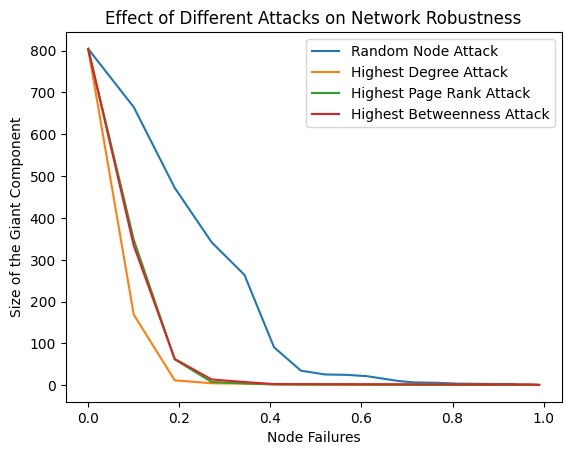

In [3]:
G = nx.erdos_renyi_graph(1000, 0.002)
giant_component = max(nx.connected_components(G), key=len)
giant_component_size = len(giant_component)
attack_types = ['Random Node Attack', 'Highest Degree Attack', 'Highest Page Rank Attack', 'Highest Betweenness Attack']
perform_attacks(G, attack_types)

## Second graph: Barabasi-Albert graph

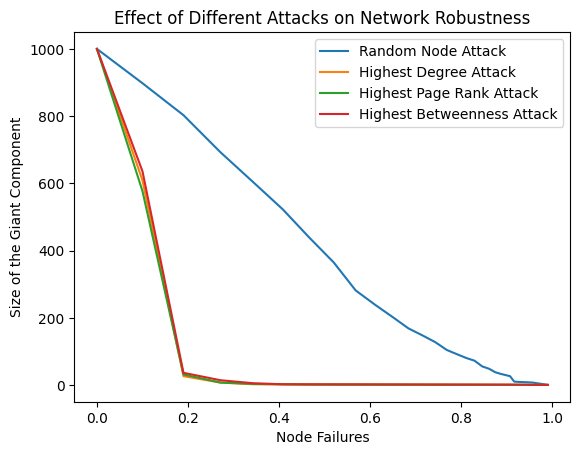

In [4]:
G = nx.barabasi_albert_graph(1000, 2)
giant_component = max(nx.connected_components(G), key=len)
giant_component_size = len(giant_component)
attack_types = ['Random Node Attack', 'Highest Degree Attack', 'Highest Page Rank Attack', 'Highest Betweenness Attack']
perform_attacks(G, attack_types)

# Part 2: Use the large graph of the other assignments

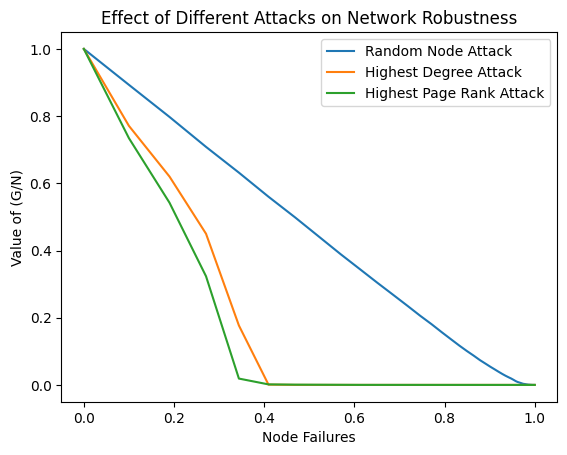

In [5]:
G = nx.read_edgelist("../data/dataset.txt", create_using=nx.Graph(), nodetype=int)
# as it is time-consuming to run the highest betweenness attack (because of calculation of betweenness) on the large graph, we will exclude it
attack_types = ['Random Node Attack', 'Highest Degree Attack', 'Highest Page Rank Attack']
perform_attacks(G, attack_types)

# Part 3: Building robustness